# Integration and joint analysis of Xenium and Visium data

Authors: Elyas Heidari, Luca Marconato

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext jupyter_black

## Setup
### Import libraries

In [3]:
import os
import warnings

os.environ["USE_PYGEOS"] = "0"
warnings.filterwarnings("ignore")

In [4]:
import shutil

import anndata
import geopandas
import napari
import numpy as np
import pandas as pd
import scanpy as sc
import spatialdata as sd
import squidpy as sq

# from napari_spatialdata import Interactive
from scipy import sparse
from shapely.geometry import Polygon
from spatialdata import aggregate
from spatialdata.transformations import (
    Affine,
    Identity,
    Sequence,
    align_elements_using_landmarks,
    get_transformation,
    set_transformation,
)

### Data paths

#### Setting up the root data folders

In [5]:
print("current working directory:", os.getcwd())
SPATIALDATA_SANDBOX_PATH = "spatialdata-sandbox"
assert os.path.isdir(
    SPATIALDATA_SANDBOX_PATH
), f"{SPATIALDATA_SANDBOX_PATH} not found, please use symlinks to make it available"
GENERATED_DATA_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "generated_data/xenium_visium_integration")
os.makedirs(GENERATED_DATA_PATH, exist_ok=True)

current working directory: /Users/macbook/embl/projects/basel/spatialdata-notebooks/notebooks/paper_reproducibility


#### Data to be downloaded

scRNA-Seq reference atlas from [Wu et al., Nat. Genet 2021](https://www.nature.com/articles/s41588-021-00911-1). It can be [downloaded from here](https://s3.embl.de/spatialdata/spatialdata-sandbox/generated_data/xenium_visium_integration/BC_atlas_xe.h5ad).

In [6]:
BC_SC_ATLAS_PATH = os.path.join(GENERATED_DATA_PATH, "BC_atlas_xe.h5ad")

Clonal information derived from the Visium data, [can be downloaded from here](https://s3.embl.de/spatialdata/spatialdata-sandbox/generated_data/xenium_visium_integration/visium_copyKat.h5ad).

In [7]:
VISIUM_CLONAL_PATH = os.path.join(GENERATED_DATA_PATH, "visium_copyKat.h5ad")

Zarr file with annotated landmark locations and a ROI polygon, drawn with napari-spatialdata and saved into a SpatialData object, [can be downloaded from here](https://s3.embl.de/spatialdata/spatialdata-sandbox/generated_data/xenium_visium_integration/sandbox.zarr.zip).

Note: some software for extracting `.zip` files will create an outer folder called `sandbox.zarr`, resulting in a directory structure like `sandbox.zarr/sandbox.zarr/`. Please ensure that only the inner `sandbox.zarr` is present (the one containing the `.zgroup` file).

In [8]:
LANDMARKS_SDATA_PATH = os.path.join(GENERATED_DATA_PATH, "sandbox.zarr")

#### Data converted to Zarr with scripts from `spatialdata-sandbox` (can also be downloaded)

To get this data:
1. run spatialdata-sandbox/xenium_rep1_io/download.py;
2. run spatialdata-sandbox/xenium_rep1_io/to_zarr.py to create the zarr files.
Alternatively, it [can be downloaded from here](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep1_io.zip).

In [9]:
XE_REP1_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep1_io/data.zarr")

To get this data:
1. run spatialdata-sandbox/xenium_rep2_io/download.py;
2. run spatialdata-sandbox/xenium_rep2_io/to_zarr.py to create the zarr files.
Alternatively, it [can be downloaded from here](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep2_io.zip).

In [10]:
XE_REP2_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep2_io/data.zarr")

To get this data:
1. run spatialdata-sandbox/visium_associated_xenium_io/download.py
2. run spatialdata-sandbox/visium_associated_xenium_io/to_zarr.py to create the zarr files
Alternatively, it [can be downloaded from here](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_associated_xenium_io.zip).

In [11]:
VISIUM_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "visium_associated_xenium_io/data.zarr")

#### Checking that all the data paths are available.

In [12]:
paths = [
    BC_SC_ATLAS_PATH,
    VISIUM_CLONAL_PATH,
    XE_REP1_PATH,
    XE_REP2_PATH,
    VISIUM_PATH,
    LANDMARKS_SDATA_PATH,
]
for path in paths:
    assert os.path.exists(path), f"{path} not found"

#### Data that will be generated by this notebook

The notebook will update in-place some of the root files above, and will also create the following Zarr files

In [13]:
# output paths for xenium_rep1, xenium_rep2 and visium data, after subsetting to the common area and being transformed
XE_REP1_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "xe_rep1_roi.zarr")
XE_REP2_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "xe_rep2_roi.zarr")
VISIUM_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "visium_roi.zarr")

### Loading the data

In [14]:
bc_sc_atlas_adata = sc.read(BC_SC_ATLAS_PATH)
bc_sc_atlas_adata.obs["dataset"] = "atlas"

xe_rep1_sdata = sd.read_zarr(XE_REP1_PATH)
xe_rep1_adata = xe_rep1_sdata["table"]
xe_rep1_adata.obs["dataset"] = "xe_rep1"

xe_rep2_sdata = sd.read_zarr(XE_REP2_PATH)
xe_rep2_adata = xe_rep2_sdata["table"]
xe_rep2_adata.obs["dataset"] = "xe_rep2"

visium_sdata = sd.read_zarr(VISIUM_PATH)
visium_adata = visium_sdata["table"]
visium_adata.obs["dataset"] = "visium"

landmarks_sdata = sd.read_zarr(LANDMARKS_SDATA_PATH)
clonal_adata = sc.read(VISIUM_CLONAL_PATH)

In [15]:
landmarks_sdata

SpatialData object, with associated Zarr store: /Users/macbook/embl/projects/basel/spatialdata-sandbox/generated_data/xenium_visium_integration/sandbox.zarr
└── Shapes
      ├── 'box': GeoDataFrame shape: (1, 1) (2D shapes)
      ├── 'rois': GeoDataFrame shape: (4, 1) (2D shapes)
      ├── 'visium_lm': GeoDataFrame shape: (3, 2) (2D shapes)
      ├── 'xe_rep1_lm': GeoDataFrame shape: (3, 2) (2D shapes)
      └── 'xe_rep2_lm': GeoDataFrame shape: (3, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        box (Shapes), rois (Shapes), visium_lm (Shapes), xe_rep1_lm (Shapes), xe_rep2_lm (Shapes)

### Integrating annotations

#### Transferring cell-types into Xenium

Let's transfer the cell-types information from an single-cell atlas dataset to the Xenium cells. We will cache the result.

In [16]:
def annotate_bc_xe(bc_sc_atlas_adata, adata_query):
    genes = list(set(bc_sc_atlas_adata.var_names) & set(adata_query.var_names))
    bc_sc_atlas_adata = bc_sc_atlas_adata[:, genes]
    adata_query = adata_query[:, genes]
    sc.pp.normalize_total(adata_query, target_sum=1e4)
    sc.pp.log1p(adata_query)

    sc.pp.pca(bc_sc_atlas_adata)
    sc.pp.neighbors(bc_sc_atlas_adata)
    sc.tl.umap(bc_sc_atlas_adata)
    sc.tl.ingest(adata_query, bc_sc_atlas_adata, obs="celltype_major")

    ad = {}
    for t in adata_query.obs["celltype_major"].unique():
        query_sub = adata_query[adata_query.obs["celltype_major"] == t]
        ref_sub = bc_sc_atlas_adata[bc_sc_atlas_adata.obs["celltype_major"] == t]
        sc.pp.pca(ref_sub)
        sc.pp.neighbors(ref_sub)
        sc.tl.umap(ref_sub)
        sc.tl.ingest(query_sub, ref_sub, obs="celltype_minor", inplace=True)
        ad[t] = query_sub

    adata_query = anndata.concat(ad)
    return adata_query

In [17]:
%%time
CELL_TYPES_ALREADY_TRANSFERRED = True
if not CELL_TYPES_ALREADY_TRANSFERRED:
    # this code can take 10-60 min to execute
    xe_rep1_annotated = annotate_bc_xe(bc_sc_atlas_adata, xe_rep1_adata)
    xe_rep2_annotated = annotate_bc_xe(bc_sc_atlas_adata, xe_rep2_adata)
    xe_rep1_annotated.write(os.path.join(GENERATED_DATA_PATH, "xe_rep1_annotated.h5ad"))
    xe_rep2_annotated.write(os.path.join(GENERATED_DATA_PATH, "xe_rep2_annotated.h5ad"))
else:
    xe_rep1_annotated = sc.read(os.path.join(GENERATED_DATA_PATH, "xe_rep1_annotated.h5ad"))
    xe_rep2_annotated = sc.read(os.path.join(GENERATED_DATA_PATH, "xe_rep2_annotated.h5ad"))

CPU times: user 131 ms, sys: 85.2 ms, total: 216 ms
Wall time: 287 ms


In [18]:
xe_rep1_sdata["table"].obs[["celltype_major", "celltype_minor"]] = xe_rep1_annotated.obs[
    ["celltype_major", "celltype_minor"]
]
xe_rep2_sdata["table"].obs[["celltype_major", "celltype_minor"]] = xe_rep2_annotated.obs[
    ["celltype_major", "celltype_minor"]
]

#### Adding clonality information into Visium

In [19]:
clones = clonal_adata.obs.set_index("barcode").loc[visium_sdata["table"].obs.index]["clone"]
visium_sdata["table"].obs["clone"] = clones

## Spatial alignment

### Alignment using 3 landmarks points

We take `xe_rep1` as the reference section and align the other two to it. The new coordinate systems is called `aligned`.

In [20]:
xenium_subset = sd.SpatialData(
    images={
        "xe_rep1": xe_rep1_sdata.images["morphology_mip"],
        "xe_rep2": xe_rep2_sdata.images["morphology_mip"],
        "visium": visium_sdata.images["CytAssist_FFPE_Human_Breast_Cancer_full_image"],
    }
)

In [21]:
# this creates the 'aligned` coordinate system, maps the moving (xenium rep 2) and reference elements (xenium rep 1) to that system
affine_rep2_to_rep1 = align_elements_using_landmarks(
    references_coords=landmarks_sdata.shapes["xe_rep1_lm"],
    moving_coords=landmarks_sdata.shapes["xe_rep2_lm"],
    reference_element=xenium_subset.images["xe_rep1"],
    moving_element=xenium_subset.images["xe_rep2"],
    reference_coordinate_system="global",
    moving_coordinate_system="global",
    new_coordinate_system="aligned",
)

In [22]:
# same as above. Now the moving element is visium and the reference element is again xenium rep 1
affine_visium_to_rep1 = align_elements_using_landmarks(
    references_coords=landmarks_sdata.shapes["xe_rep1_lm"],
    moving_coords=landmarks_sdata.shapes["visium_lm"],
    reference_element=xenium_subset.images["xe_rep1"],
    moving_element=xenium_subset.images["visium"],
    reference_coordinate_system="global",
    moving_coordinate_system="global",
    new_coordinate_system="aligned",
)

For each element of xenium rep 1, xenium rep 2 and of visium, let's add a transformation to the coordinate system 'aligned'. This instruct the framework how to map each element to the 'aligned' coordinate system.

This part of the code will be simplified and become more ergonomic after the new coordinate systems refactoring.

In [23]:
# we use an identity for xenium rep 1 since we use it as a reference
from spatialdata import SpatialData
from spatialdata.transformations import BaseTransformation


def postpone_transformation(
    sdata: SpatialData,
    transformation: BaseTransformation,
    source_coordinate_system: str,
    target_coordinate_system: str,
):
    for element_type, element_name, element in sdata._gen_elements():
        old_transformations = get_transformation(element, get_all=True)
        if source_coordinate_system in old_transformations:
            old_transformation = old_transformations[source_coordinate_system]
            sequence = Sequence([old_transformation, transformation])
            set_transformation(element, sequence, target_coordinate_system)


postpone_transformation(
    sdata=xe_rep1_sdata,
    transformation=Identity(),
    source_coordinate_system="global",
    target_coordinate_system="aligned",
)
postpone_transformation(
    sdata=xe_rep2_sdata,
    transformation=affine_rep2_to_rep1,
    source_coordinate_system="global",
    target_coordinate_system="aligned",
)
postpone_transformation(
    sdata=visium_sdata,
    transformation=affine_visium_to_rep1,
    source_coordinate_system="global",
    target_coordinate_system="aligned",
)

### Subsetting of the data
Used for debugging and dev purposes, remove later

### Subsetting the objects to the common area

We now want to subset each object to the common area between the two Xenium replicates and the Visium data. Currently there is no function available in `spatialdata` to do a spatial subset by a generic polygon (it will be implemented), so for performing this opertation we will manually transform the data to the same coordinate system, and then implement here a version of the spatial subset.

#### Transforming cells and single-molecule points

We will now transform the data to the `aligned` coordinate system. Note that above we just defined transformations to this coordinate system but we didn't modified the data itself (this is an expensive operation). Let's create new objects that don't contain the large images.

In [24]:
xe_rep1_transformed_sdata = sd.SpatialData(
    shapes=xe_rep1_sdata.shapes, points=xe_rep1_sdata.points, tables={"table": xe_rep1_sdata["table"]}
)

xe_rep2_transformed_sdata = sd.SpatialData(
    shapes=xe_rep2_sdata.shapes, points=xe_rep2_sdata.points, tables={"table": xe_rep2_sdata["table"]}
)

visium_transformed_sdata = sd.SpatialData(
    shapes=visium_sdata.shapes, points=visium_sdata.points, tables={"table": visium_sdata["table"]}
)

xe_rep1_transformed_sdata = xe_rep1_transformed_sdata.transform_to_coordinate_system("aligned")
xe_rep2_transformed_sdata = xe_rep2_transformed_sdata.transform_to_coordinate_system("aligned")
visium_transformed_sdata = visium_transformed_sdata.transform_to_coordinate_system("aligned")

#### Getting the polygon describing the common area

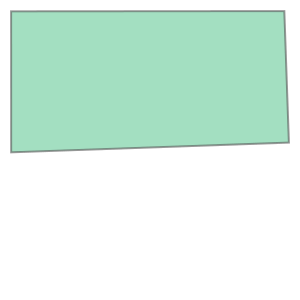

In [25]:
# we manually draw the polygon that contains the common area between the samples
box = landmarks_sdata.shapes["box"]
# let's get the Polygon object out of the GeoDataFrame
box = box.geometry.iloc[0]
box

#### Filtering the data inside the common area

The functions below implement spatial queries operations on polygons. These functions will be implemented in SpatialData and the code will become simpler.

In [26]:
from spatialdata import polygon_query

In [27]:
%%time
# let's keep only the shapes inside the query polygon (roi)
xe_rep1_roi_sdata = polygon_query(
    xe_rep1_transformed_sdata, polygon=box, target_coordinate_system="aligned", filter_table=False
)

CPU times: user 1min 22s, sys: 27.7 s, total: 1min 49s
Wall time: 1min 55s


In [28]:
%%time
xe_rep2_roi_sdata = polygon_query(
    xe_rep2_transformed_sdata, polygon=box, target_coordinate_system="aligned", filter_table=False
)

CPU times: user 1min 13s, sys: 18.3 s, total: 1min 32s
Wall time: 1min 29s


In [29]:
%%time
visium_roi_sdata = polygon_query(
    visium_transformed_sdata,
    polygon=box,
    target_coordinate_system="aligned",
)

CPU times: user 102 ms, sys: 69 ms, total: 171 ms
Wall time: 171 ms


### Subsetting the objects to the common genes

In [30]:
from copy import copy

sel_genes = list(set(visium_roi_sdata["table"].var_names) & (set(xe_rep1_roi_sdata["table"].var_names)))

filtered_table = xe_rep1_roi_sdata["table"][:, sel_genes].copy()
del xe_rep1_roi_sdata.tables["table"]
xe_rep1_roi_sdata["table"] = filtered_table

filtered_table = xe_rep2_roi_sdata["table"][:, sel_genes].copy()
del xe_rep2_roi_sdata.tables["table"]
xe_rep2_roi_sdata["table"] = filtered_table

filtered_table = visium_roi_sdata["table"][:, sel_genes].copy()
del visium_roi_sdata.tables["table"]
visium_roi_sdata["table"] = filtered_table

## Aggregation of gene expression and cell-types from the Xenium cells into the Visium circles

We will now aggregate the gene expression and the cell-type information and the into the Visium circles.

To do so, we will consider the polygonal cell description. Currently the table is set to describe the cell circles (as we can see in the next cell). Therefore, let's create another `SpatialData` object that links the table to the polygonal description, and let's use this for aggregation. Let's do this for both replicates.

The option `fractions=True` is used to downweigh cases of partial cell overlaps, please refer to the documentation for a detailed explanation.

In [31]:
from spatialdata.models import TableModel

table_metadata = xe_rep1_roi_sdata["table"].uns[TableModel.ATTRS_KEY]
print(table_metadata)

# replicate 1
new_table = xe_rep1_roi_sdata["table"].copy()
del new_table.uns[TableModel.ATTRS_KEY]
new_table.obs["region"] = "cell_boundaries"
new_table.obs["region"] = new_table.obs["region"].astype("category")
new_table = TableModel.parse(new_table, region="cell_boundaries", region_key="region", instance_key="cell_id")
xe_rep1_roi_sdata_polygons = SpatialData(
    shapes={"cell_boundaries": xe_rep1_roi_sdata["cell_boundaries"]}, tables={"table": new_table}
)

# replicate 2
new_table = xe_rep2_roi_sdata["table"].copy()
del new_table.uns[TableModel.ATTRS_KEY]
new_table.obs["region"] = "cell_boundaries"
new_table.obs["region"] = new_table.obs["region"].astype("category")
new_table = TableModel.parse(new_table, region="cell_boundaries", region_key="region", instance_key="cell_id")
xe_rep2_roi_sdata_polygons = SpatialData(
    shapes={"cell_boundaries": xe_rep2_roi_sdata["cell_boundaries"]}, tables={"table": new_table}
)

{'instance_key': 'cell_id', 'region': 'cell_circles', 'region_key': 'region'}


### Aggregating gene expression.

In [32]:
%%time
# rep 1
agg_expression = aggregate(
    values_sdata=xe_rep1_roi_sdata_polygons,
    values="cell_boundaries",
    by_sdata=visium_roi_sdata,
    by="CytAssist_FFPE_Human_Breast_Cancer",
    value_key=xe_rep1_roi_sdata["table"].var_names.tolist(),
    target_coordinate_system="aligned",
    fractions=True,
)
visium_roi_sdata["table"].layers["xe_rep1_cells"] = agg_expression["table"][:, sel_genes].X.copy()

# rep 2
agg_expression = aggregate(
    values_sdata=xe_rep2_roi_sdata_polygons,
    values="cell_boundaries",
    by_sdata=visium_roi_sdata,
    by="CytAssist_FFPE_Human_Breast_Cancer",
    value_key=xe_rep2_roi_sdata["table"].var_names.tolist(),
    target_coordinate_system="aligned",
    fractions=True,
)
visium_roi_sdata["table"].layers["xe_rep2_cells"] = agg_expression["table"][:, sel_genes].X.copy()

CPU times: user 4.21 s, sys: 364 ms, total: 4.57 s
Wall time: 4.58 s


### Aggregating cell-types into cell-type fractions

#### Major cell-types

In [33]:
%%time
# rep 1
agg_celltype_major = aggregate(
    values_sdata=xe_rep1_roi_sdata_polygons,
    values="cell_boundaries",
    by_sdata=visium_roi_sdata,
    by="CytAssist_FFPE_Human_Breast_Cancer",
    value_key="celltype_major",
    target_coordinate_system="aligned",
    fractions=True,
)
visium_roi_sdata["table"].obsm["xe_rep1_celltype_major"] = agg_celltype_major["table"].X.A

# rep 2
agg_celltype_major = aggregate(
    values_sdata=xe_rep2_roi_sdata_polygons,
    values="cell_boundaries",
    by_sdata=visium_roi_sdata,
    by="CytAssist_FFPE_Human_Breast_Cancer",
    value_key="celltype_major",
    target_coordinate_system="aligned",
    fractions=True,
)
visium_roi_sdata["table"].obsm["xe_rep2_celltype_major"] = agg_celltype_major["table"].X.A

CPU times: user 3.35 s, sys: 111 ms, total: 3.46 s
Wall time: 3.46 s


#### Minor cell-types

In [34]:
%%time
# rep 1
agg_celltype_minor = aggregate(
    values_sdata=xe_rep1_roi_sdata_polygons,
    values="cell_boundaries",
    by_sdata=visium_roi_sdata,
    by="CytAssist_FFPE_Human_Breast_Cancer",
    value_key="celltype_minor",
    target_coordinate_system="aligned",
    fractions=True,
)
visium_roi_sdata["table"].obsm["xe_rep1_celltype_minor"] = agg_celltype_minor["table"].X.A

# rep 2
agg_celltype_minor = aggregate(
    values_sdata=xe_rep2_roi_sdata_polygons,
    values="cell_boundaries",
    by_sdata=visium_roi_sdata,
    by="CytAssist_FFPE_Human_Breast_Cancer",
    value_key="celltype_minor",
    target_coordinate_system="aligned",
    fractions=True,
)
visium_roi_sdata["table"].obsm["xe_rep2_celltype_minor"] = agg_celltype_minor["table"].X.A

CPU times: user 3.3 s, sys: 67.4 ms, total: 3.36 s
Wall time: 3.36 s


## Aggregation of gene expression from the Xenium single-molecule points into the Visium Circles

In [35]:
%%time
xe_rep1_aggregated = aggregate(
    values=xe_rep1_roi_sdata["transcripts"],
    by=visium_roi_sdata["CytAssist_FFPE_Human_Breast_Cancer"],
    value_key="feature_name",
    agg_func="count",
    target_coordinate_system="aligned",
)

CPU times: user 28.7 s, sys: 8.8 s, total: 37.5 s
Wall time: 39.4 s


In [36]:
counts = xe_rep1_aggregated["table"][:, sel_genes].X.todense().A
visium_roi_sdata["table"].layers["xe_rep1_tx"] = counts

In [37]:
%%time
xe_rep2_aggregated = aggregate(
    values=xe_rep2_roi_sdata["transcripts"],
    by=visium_roi_sdata["CytAssist_FFPE_Human_Breast_Cancer"],
    value_key="feature_name",
    agg_func="count",
    target_coordinate_system="aligned",
)

CPU times: user 28.5 s, sys: 8.5 s, total: 37 s
Wall time: 39.4 s


In [38]:
counts = xe_rep2_aggregated["table"][:, sel_genes].X.todense().A
visium_roi_sdata["table"].layers["xe_rep2_tx"] = counts

## Saving the objects to disk

### Saving the SpatialData for the polygonal ROI

In [39]:
xe_rep1_roi_sdata

SpatialData object
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (100849, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (100637, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (100646, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (167780, 307)
with coordinate systems:
    ▸ 'aligned', with elements:
        transcripts (Points), cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (Shapes)

In [40]:
xe_rep2_roi_sdata

SpatialData object
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (99923, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (99770, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (99761, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (118752, 307)
with coordinate systems:
    ▸ 'aligned', with elements:
        transcripts (Points), cell_boundaries (Shapes), cell_circles (Shapes), nucleus_boundaries (Shapes)

In [41]:
visium_roi_sdata

SpatialData object
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (2826, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (2826, 307)
with coordinate systems:
    ▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer (Shapes)

In [42]:
xe_rep1_roi_sdata["transcripts"]["feature_name"] = xe_rep1_roi_sdata["transcripts"]["feature_name"].cat.as_known()
xe_rep2_roi_sdata["transcripts"]["feature_name"] = xe_rep2_roi_sdata["transcripts"]["feature_name"].cat.as_known()

In [43]:
%%time
import shutil

if os.path.isdir(XE_REP1_ROI_PATH):
    shutil.rmtree(XE_REP1_ROI_PATH)
xe_rep1_roi_sdata.write(XE_REP1_ROI_PATH)

if os.path.isdir(XE_REP2_ROI_PATH):
    shutil.rmtree(XE_REP2_ROI_PATH)
xe_rep2_roi_sdata.write(XE_REP2_ROI_PATH)

if os.path.isdir(VISIUM_ROI_PATH):
    shutil.rmtree(VISIUM_ROI_PATH)
visium_roi_sdata.write(VISIUM_ROI_PATH)

INFO     The Zarr backing store has been changed from None the new file path:                                      
         spatialdata-sandbox/generated_data/xenium_visium_integration/xe_rep1_roi.zarr                             
INFO     The Zarr backing store has been changed from None the new file path:                                      
         spatialdata-sandbox/generated_data/xenium_visium_integration/xe_rep2_roi.zarr                             
INFO     The Zarr backing store has been changed from None the new file path:                                      
         spatialdata-sandbox/generated_data/xenium_visium_integration/visium_roi.zarr                              
CPU times: user 11.2 s, sys: 3.56 s, total: 14.8 s
Wall time: 15.6 s


### Saving elements in the SpatialData object on disk

We have new "incremental IO" APIs in the `spatialdata` library. The following cells show how to use the new incremental IO APIs. These APIs allow to store elements in the SpatialData zarr store in a fashion that does not require you delete the whole zarr store and create a new one. Instead elements can be deleted and written directly in the zarr store. Below we show the safest way for "overwriting" an element in a SpatialData zarr store.

In [ ]:
# save transformations to disk (it was only in-memory so far)

xe_rep1_sdata.write_transformations()
xe_rep2_sdata.write_transformations()
visium_sdata.write_transformations()

The table of the xenium data was modified only in-memory, let's sync the change to disk

In [ ]:
# importantly, the pattern below is used to avoid the risk of losing the original table is this cell is killed while rewriting the original one
# this approach works for this notebook, but it other contexts, like with network storages or multithread environment, it may not prevent data
# corruption. As a user, it is important to take this factors into consideration and implement a strategy to minimize the risk of data loss.
def replace_table(sdata):
    # copy the table to a backup table
    sdata["backup_table"] = sdata["table"]
    sdata.write_element("backup_table")

    # rewrite the original one
    sdata.delete_element_from_disk("table")
    sdata.write_element("table")

    # remove the backup copy
    sdata.delete_element_from_disk("backup_table")
    del sdata.tables["backup_table"]

In [ ]:
replace_table(xe_rep1_sdata)

In [ ]:
replace_table(xe_rep2_sdata)

In [ ]:
replace_table(visium_sdata)

The full dataset is rewritten below under the section "Internal code", which is primarily used for automatic testing purposes.

### Internal code

For interal pipelines used during development, we also copy the produced data into a new location.

In [1]:
XE_REP1_ALIGNED_PATH = XE_REP1_PATH.replace("data.zarr", "data_aligned.zarr")
XE_REP2_ALIGNED_PATH = XE_REP2_PATH.replace("data.zarr", "data_aligned.zarr")
VISIUM_ALIGNED_PATH = VISIUM_PATH.replace("data.zarr", "data_aligned.zarr")

NameError: name 'XE_REP1_PATH' is not defined

In [ ]:
%%time

if os.path.isdir(XE_REP1_ALIGNED_PATH):
    shutil.rmtree(XE_REP1_ALIGNED_PATH)
xe_rep1_sdata.write(XE_REP1_ALIGNED_PATH)

if os.path.isdir(XE_REP2_ALIGNED_PATH):
    shutil.rmtree(XE_REP2_ALIGNED_PATH)
xe_rep2_sdata.write(XE_REP2_ALIGNED_PATH)

if os.path.isdir(VISIUM_ALIGNED_PATH):
    shutil.rmtree(VISIUM_ALIGNED_PATH)
visium_sdata.write(VISIUM_ALIGNED_PATH)